In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from tqdm import tqdm
from monai.data import CacheDataset, Dataset, list_data_collate
from monai.transforms import (
    AsChannelFirstd,
    AddChanneld,
    AsDiscreted,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    RandRotated,
    RandZoomd,
    Rotated,
    ScaleIntensityd,
    ScaleIntensityRanged,
    Transposed,
    EnsureTyped,
    RandAffined,
    Transform,
    MapTransform,
    RandGibbsNoised,
    RandKSpaceSpikeNoised,
    RandGaussianNoised,
    RandCoarseDropoutd,
    ResizeWithPadOrCropd,
)

# ensure is in parent directory
try:
    print(os.getcwd())
    os.chdir("../../rug-hr/")
    print(os.getcwd())
except:
    pass

## Experiment setup

In [2]:
config = {
    "epochs": 200,
    "batch_size": 4,
    "learning_rate": 1e-4,
    "architecture": "VizBERTForMaskedLM",
    "dataset": "IAM-data",
    "spatial_size": [128, 2048],
    "splits": [0.85, 0.1],
    "model_output_name": "vizbert_masked.pt",
    "name": "IAM handwriting recognition",
    "description": "",
    "pretrained_model": None,
    "max_sequence_length": 64,
    "language_model": "bert-base-uncased",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

In [3]:
import wandb 
def init_experiment(config=config):
    wandb.init(
        project="handwriting-recognition-iam",
        config=config,
    )

def terminate_experiment():
    wandb.finish()

def log(data):
    wandb.log(data)

## Language Models

In [4]:
from transformers import AutoTokenizer, BertForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForMaskedLM.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Data setup

Some notes:
- Max height: 342; Max width: 2260
- Min height: 44; Min width: 100
- Mean height: 121.56060606060606; Mean width: 1693.719093590775
- Max tokens: 27

In [5]:
dataset_name = config["dataset"]
files = glob(f"./datasets/{dataset_name}/img/*")
metadata = f"./datasets/{dataset_name}/iam_lines_gt.txt"
fraction = 1


def sentence2onehot_tokens(sentence):
    encodings = tokenizer.encode_plus(
        sentence, 
        add_special_tokens=True, 
        max_length=config["max_sequence_length"], 
        padding="max_length", 
        truncation=True, 
        return_tensors="pt")
    tokens = encodings["input_ids"].squeeze()
    tokens = torch.nn.functional.one_hot(tokens, num_classes=tokenizer.vocab_size).squeeze()
    return tokens

with open(metadata, "r") as f:
    metadata = f.read().strip("\n").split("\n")
    metadata = [line for line in metadata if line]
    # files are in odd positions, labels in even positions
    filenames = [line for i, line in enumerate(metadata) if i % 2 == 0]
    labels = [line for i, line in enumerate(metadata) if i % 2 == 1]
    filename2label = dict(zip(filenames, labels))

metadata = [{
    "image": path, 
    "label": filename2label.get(os.path.basename(path), None),
    "filename": os.path.basename(path)
} for path in files]
random.shuffle(metadata)
metadata = metadata[:int(len(metadata) * fraction)]

# Encode sentences
for meta in tqdm(metadata, desc="encoding...", total=len(metadata)):
    meta["label"] = sentence2onehot_tokens(meta["label"])

# split into training, validation and test set
split_train = int(len(metadata) * config["splits"][0])
split_validation = int(len(metadata) * (config["splits"][1] + config["splits"][0]))

train_metadata = metadata[:split_train]
validation_metadata = metadata[split_train:split_validation]
test_metadata = metadata[split_validation:]

print(f"Train: {len(train_metadata)}; Validation: {len(validation_metadata)}; Test: {len(test_metadata)}")
print(f"Example: {train_metadata[0]}")

encoding...: 100%|██████████| 7458/7458 [00:44<00:00, 168.76it/s] 


Train: 5220; Validation: 1492; Test: 746
Example: {'image': './datasets/IAM-data/img\\c04-023-02.png', 'label': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]]), 'filename': 'c04-023-02.png'}


In [6]:

class Invert(Transform):
    def __call__(self, data, max_value=1.0, min_value=0.0):
        return max_value - data + min_value

class Invertd(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        self.invert = Invert()

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = self.invert(d[key])
        return d
    
class Bertify(Transform):
    # hugging face tokenizer
    def __init__(self, tokenizer, pad_to_sequence_length=True, max_sequence_length=64):
        self.tokenizer = tokenizer
        self.pad_to_sequence_length = pad_to_sequence_length
        self.max_sequence_length = max_sequence_length

    def __call__(self, sentence):
        # feed to bert
        return sentence2onehot_tokens(sentence)

class Bertifyd(MapTransform):
    def __init__(self, keys, *argc, **kwargs):
        super().__init__(keys)
        self.tokenizer = Bertify(*argc, **kwargs)

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = self.tokenizer(d[key])
        return d

train_transforms = Compose([
    # Image transformations
    LoadImaged(keys=["image"]),
    AddChanneld(keys=["image"]),
    Transposed(keys=["image"], indices=[0, -1, -2]),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    Invertd(keys=["image"]),
    ResizeWithPadOrCropd(keys=["image"], spatial_size=config["spatial_size"], mode="constant"),
    RandCoarseDropoutd(keys=["image"], holes=128, spatial_size=(8, 8), max_holes=128, fill_value=0, prob=0.5),
    RandGaussianNoised(keys=["image"], mean=0.0, std=0.02, prob=0.7),
    RandKSpaceSpikeNoised(keys=["image"], prob=0.5),
    RandAffined(keys=["image"], prob=0.5, rotate_range=(0, 0, np.pi/8), scale_range=(0.1, 0.1, 0.1)),
    RandShiftIntensityd(keys=["image"], offsets=0.1, prob=0.5),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image"]),
    # Sentence transformations
    # Bertifyd(keys=["label"], tokenizer=tokenizer, pad_to_sequence_length=True, max_sequence_length=config["max_sequence_length"]),
    EnsureTyped(keys=["label"]),
])

image: torch.Size([1, 128, 2048])
range: tensor(0.) tensor(0.8229)
label: torch.Size([64, 30522])


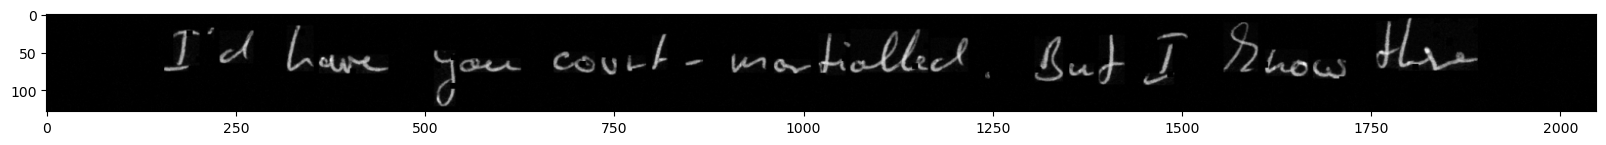

In [7]:
# example
choice = random.choice(train_metadata)
output = train_transforms(choice)
print("image:", output["image"].shape)
print("range:", output["image"].min(), output["image"].max())
print("label:", output["label"].shape)
plt.figure(figsize=(20, 10))
plt.imshow(output["image"][0], cmap="gray")
plt.show()

In [8]:
train_dataset = Dataset(data=train_metadata, transform=train_transforms)
validation_dataset = Dataset(data=validation_metadata, transform=train_transforms)
test_dataset = Dataset(data=test_metadata, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"])
validation_loader = DataLoader(validation_dataset, batch_size=config["batch_size"])
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"])

In [9]:
from modules.vizseq.model import VizSeqMasked
from modules.vizseq.trainer import VizSeqTrainer

model = VizSeqMasked(
    spatial_size=config["spatial_size"], 
    max_seq_length=config["max_sequence_length"]
).to(config["device"])


trainer = VizSeqTrainer(
    model=model,
    model_name=config["model_output_name"],
    device=config["device"],
)

print(f"num_params: {sum(p.numel() for p in model.parameters())}; model_size (MB) {sum(p.numel() for p in model.parameters()) * 4 / 1024 / 1024}")


num_params: 157183674; model_size (MB) 599.6081314086914


In [10]:
sample = next(iter(train_loader))
mask = torch.ones(4, *config["spatial_size"], dtype=torch.float32).to(config["device"])
image = sample["image"].to(config["device"])
label = sample["label"].to(config["device"])
print("image.shape = ", image.shape)
print("label.shape = ", label.shape)
print("mask.shape = ", mask.shape)
# feed sample to model
output = model(image, mask)
print("output.shape = ", output.shape)


image.shape =  torch.Size([4, 1, 128, 2048])
label.shape =  torch.Size([4, 64, 30522])
mask.shape =  torch.Size([4, 128, 2048])
output.shape =  torch.Size([4, 64, 30522])


In [11]:
init_experiment(config)
trainer.train(
    trainloader=train_loader,
    valloader=validation_loader,
    epochs=config["epochs"],
    learning_rate=config["learning_rate"],
    log=log
    # log=print
)
terminate_experiment()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: massaf (rug-ai-group). Use `wandb login --relogin` to force relogin


epochs=200; N=5220; batches=1305; learning_rate=0.0001


 31%|███       | 116/373 [00:29<01:12,  3.55it/s]

torch.Size([8, 1, 128, 2048])
torch.Size([8, 64, 30522])


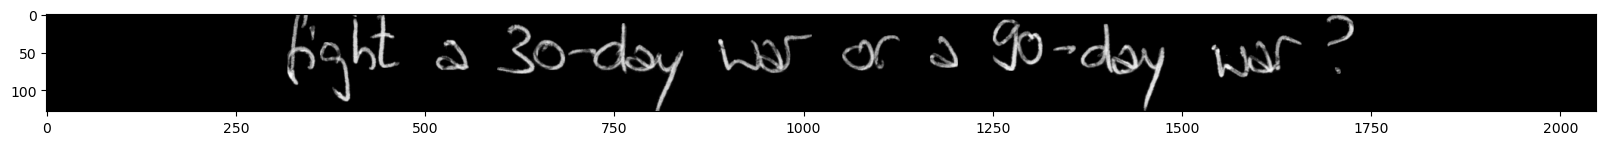

['.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.']

In [ ]:
sample = next(iter(train_loader))
print(sample["image"].shape)
print(sample["label"].shape)
# feed sample to model
output = model.predict_tokens(sample["image"].to(config["device"]))

# plot image
plt.figure(figsize=(20, 10))
plt.imshow(sample["image"][0][0], cmap="gray")
plt.show()
output[0]

In [ ]:
# decode label
ids = torch.argmax(sample["label"][0], dim=-1)
tokenizer.decode(ids)

'?. a 30 - day war or a 90 - day war?.?????????? or???? one or or? or a, a a?????????? fight????? do fight a 30 - day? or a'